# Tomography in the Pauli basis

In [1]:
import numpy as np
import scipy.integrate
import time
import qutip as qtp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pysqkit
from pysqkit import QubitSystem, Qubit
from pysqkit.drives.pulse_shapes import gaussian_top
from pysqkit.util.metrics import average_process_fidelity, \
    average_gate_fidelity
from pysqkit.util.phys import temperature_to_thermalenergy
from pysqkit.util.quantum import generalized_rabi_frequency
import pysqkit.util.transformations as trf
from pysqkit.util.linalg import get_mat_elem, tensor_prod, \
    hilbert_schmidt_prod
from pysqkit.solvers.solvkit import integrate
from pysqkit.util.hsbasis import weyl_by_index
from pysqkit.solvers import solvkit
from pysqkit.drives.pulse_shapes import gaussian_top
import qutip
from typing import List, Dict, Callable, Union
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import copy
import json
import cmath

from IPython.display import display, Latex

In [2]:
temperature = 0.020 #0.020 # K
thermal_energy = temperature_to_thermalenergy(temperature) # kb T/h in GHz
d_comp = 4

p_set = "3"


#Transmon
levels_t = 3
transm = pysqkit.qubits.SimpleTransmon(
    label='T', 
    max_freq= 5.5, 
    anharm=-0.3,
    diel_loss_tan=1e-7,
    env_thermal_energy=thermal_energy,    
    dim_hilbert=levels_t,
    dephasing_times=None 
)

#Fluxonium
levels_f = 4

flx = pysqkit.qubits.Fluxonium(
    label='F', 
    charge_energy=1.0, 
    induct_energy=0.85, 
    joseph_energy=4.0,  
    diel_loss_tan=1e-6, 
    env_thermal_energy=thermal_energy,
    dephasing_times=None 
)
flx.diagonalize_basis(levels_f)

# We also add a drive on the fluxonium
flx.add_drive(
    pysqkit.drives.microwave_drive,
    label='cr_drive_f',
    pulse=pysqkit.drives.pulses.cos_modulation,
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)

d_leak = levels_t*levels_f - d_comp

jc = 0.02
coupled_sys = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
bare_system = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=0.0)

states_label = coupled_sys.all_state_labels()
states_dict = coupled_sys.states_as_dict(as_qobj=True)
flx_freq = flx.eig_energies(2)[1] - flx.eig_energies(2)[0]

In [3]:
state_label = ["00", "01", "10", "11"]
comp_states = {}
for label in state_label:
    state_tmp = coupled_sys.state(label)[1]
    loc = np.argmax(np.abs(state_tmp))
    phase = cmath.phase(state_tmp[loc])
    state_tmp = np.exp(-1j*phase)*state_tmp
    comp_states[label] = state_tmp

In [4]:
def pauli(xi: Union[np.ndarray, List]) -> np.ndarray:
    """ 
    Description
    --------------------------------------------------------------------------
    Returns the normalized Pauli operator on n qubits associated with the 
    binary vector xi. 
    """

    n = int(len(xi)/2)
    x = np.array([[0, 1], [1, 0]], dtype=complex)
    z = np.array([[1, 0], [0, -1]], dtype=complex)
    x_xi = np.linalg.matrix_power(x, xi[0])
    z_xi = np.linalg.matrix_power(z, xi[n])
    f = xi[0]*xi[n]
    for k in range(1, n):
        f += xi[k]*xi[n + k]
        x_xi = np.kron(x_xi, np.linalg.matrix_power(x, xi[k]))
        z_xi = np.kron(z_xi, np.linalg.matrix_power(z, xi[n + k]))
    d_xi = (1j)**f*x_xi.dot(z_xi)
    return d_xi/np.sqrt(2**n)

def decimal_to_binary(
    k: int, 
    nbit: int
    ) -> np.ndarray:
    """
    Description
    --------------------------------------------------------------------------
    Returns the integer k as a binary vector with nbit
    """

    y = np.zeros(nbit, dtype=int)
    iterate = True
    x = np.mod(k, 2)
    y[nbit - 1] = int(x)
    if nbit > 1:
        k = (k - x)/2
        l = 1
        while iterate == True:
            l += 1
            x = np.mod(k, 2)
            y[nbit - l] = int(x)
            k = (k - x)/2
            if k <= 0:
                iterate = False
    return y

def binary_to_decimal(k_bin: np.ndarray) -> int:
    """
    Description
    --------------------------------------------------------------------------
    It returns the integer associated with a binary vector
    """

    n = len(k_bin)
    y = k_bin[n-1]
    for l in range(1, n):
        y += 2**l*k_bin[n -l -1]
    return y

def pauli_by_index(
    i: int,
    d: int
) -> np.ndarray:
    """ 
    Description
    --------------------------------------------------------------------------
    Returns the normalized Pauli operator on n = log_2(d) qubits associated 
    with the integer i 
    """
    
    if np.mod(np.log2(d), 1) != 0.0 or d <= 0:
        raise ValueError("Dimension error: d must be a positive power of 2")
    
    n = int(np.log2(d))
    xi = decimal_to_binary(i, 2*n)
    
    return pauli(xi)


In [5]:
# The following functions can also be found in the util_tf_cr.py file and are here reported for clarity
# of the notebook

def zz(system: QubitSystem) -> float:
    xi_zz = system.state('00')[0] + system.state('11')[0] \
        - system.state('01')[0] - system.state('10')[0]
    return xi_zz

def mu_yz_flx(
    comp_states: List[np.ndarray], 
    op: np.ndarray,
    eps: float
) -> float:
    """
    Description
    ---------------------------------------------------------------------------
    Evaluates the CR coefficient numerically in the dressed basis when
    driving the fluxonium
    """
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'])
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(yz0 - yz1))/2*eps/2

def mu_zy_transm(
    comp_states: List[np.ndarray], 
    op: np.ndarray,
    eps: float
) -> float:
    """
    Description
    ---------------------------------------------------------------------------
    Evaluates the CR coefficient numerically in the dressed basis when
    driving the transmon
    """
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['01'])
    yz1 = get_mat_elem(op, comp_states['10'], comp_states['11'] )
    return (np.imag(yz0 - yz1))/2

def mu_yi_flx(
    comp_states: List[np.ndarray], 
    op: np.ndarray,
    eps: float
) -> float:
    """
    Description
    ---------------------------------------------------------------------------
    Evaluates the direct drive on the transmon numerically in the dressed basis 
    when driving the fluxonium
    """
    yz0 = get_mat_elem(op, comp_states['00'], comp_states['10'] )
    yz1 = get_mat_elem(op, comp_states['01'], comp_states['11'] )
    return (np.imag(yz0 + yz1))/2*eps/2

def mu_yz_flx_sw(
    transm: Qubit,
    flx: Qubit,
    jc: float,
    eps: float
):
    """
    Description
    ---------------------------------------------------------------------------
    Evaluates the CR coefficient via the second order Schrieffer-Wolff
    transformation
    """
    q_zpf = transm.charge_zpf
    omega_t = transm.freq
    omega_flx, states_flx = flx.eig_states(4)
    omega_flx = omega_flx - omega_flx[0]
    q_10 = np.imag(get_mat_elem(flx.charge_op(), states_flx[1], states_flx[0]))
    q_21 = np.imag(get_mat_elem(flx.charge_op(), states_flx[2], states_flx[1]))
    q_30 = np.imag(get_mat_elem(flx.charge_op(), states_flx[3], states_flx[0]))
    coeff = q_21**2/(omega_flx[2] - (omega_t + omega_flx[1]))
    coeff += -q_30**2/(omega_flx[3] - omega_t)
    coeff += q_10**2/(omega_t - omega_flx[1]) 
    mu_yz = jc*q_zpf*coeff/2*eps/2
    return mu_yz

In [6]:
def func_to_minimize(
    pulse_time: list,
    t_rise: float,
    cr_coeff: float
) -> float:
    step = 1e-3
    n_points = int(pulse_time[0]/step)
    times = np.linspace(0, pulse_time[0], n_points)
    pulse = gaussian_top(times, t_rise, pulse_time[0])
    integral = scipy.integrate.simpson(2*np.pi*cr_coeff*pulse, times)
    return np.abs(integral - np.pi/4)  

In [7]:
eps = 0.6
omega_flx, states_flx = flx.eig_states(4)
op = coupled_sys["F"].charge_op()
freq_drive = transm.max_freq
omega_drive = np.abs(get_mat_elem(op, coupled_sys.state("01")[1], coupled_sys.state("11")[1]))
delta_drive = freq_drive - transm.max_freq
rabi_period = 1/np.sqrt(omega_drive**2 + delta_drive**2)
t_rise = 10.0 # [ns]

t_gate_0 = [100.0]

args_to_pass = (t_rise, np.abs(mu_yz_flx_sw(transm, flx, jc, eps))) 
# We find the total time to obtain the desired gate

start = time.time()

minimization_result = minimize(func_to_minimize, t_gate_0, args=args_to_pass)

print(minimization_result)

end = time.time()

t_gate = minimization_result['x'][0] 
print("t_gate: {} ns".format(t_gate))
pts_per_drive_period = 10

nb_points = int(t_gate*freq_drive*pts_per_drive_period)
tlist = np.linspace(0, t_gate, nb_points)

coupled_sys['F'].drives['cr_drive_f'].set_params(phase=0, time=tlist, rise_time=t_rise, pulse_time=t_gate,
                                                 amp=eps, freq=freq_drive)

      fun: 5.561373583873319e-11
 hess_inv: array([[20266.28895169]])
      jac: array([1.49011612e-08])
  message: 'Optimization terminated successfully.'
     nfev: 82
      nit: 2
     njev: 41
   status: 0
  success: True
        x: array([115.79852065])
t_gate: 115.79852065162292 ns


In [8]:
simu_opt = qtp.solver.Options()
simu_opt.atol = 1e-14
simu_opt.rtol = 1e-12

env_syst = pysqkit.tomography.TomoEnv(system=coupled_sys, time=2*np.pi*tlist, options=simu_opt, 
                                      with_noise=False, dressed_noise=False)

In [9]:
comp_states_list = []
for key in comp_states.keys():
    comp_states_list.append(comp_states[key])

In [10]:
n_process = 4

my_hs_basis = pauli_by_index

start = time.time()
sup_op = env_syst.to_super(comp_states_list, my_hs_basis, n_process, speed_up=True)
end = time.time()
print("Computational time = " + str(end - start) + ' s')

Computational time = 62.84108352661133 s


In [11]:
def single_qubit_corrections(
    sup_op: np.ndarray,
    hs_basis: Callable[[int, int], np.ndarray]
) -> np.ndarray:
    # WARNING: AC sigma_m sigma_plus problem

    sigma_m1 = tensor_prod([np.array([[0.0, 0.0], [1.0, 0.0]]), 
                           np.array([[1.0, 0.0], [0.0, 0.0]])])
    sigma_m2 = tensor_prod([np.array([[1.0, 0.0], [0.0, 0.0]]), 
                           np.array([[0.0, 0.0], [1.0, 0.0]])])
    sigma_m1_vec = trf.mat_to_vec(sigma_m1, hs_basis)
    sigma_m2_vec = trf.mat_to_vec(sigma_m2, hs_basis)
    evolved_sigma_m1_vec = sup_op.dot(sigma_m1_vec)
    evolved_sigma_m2_vec = sup_op.dot(sigma_m2_vec)
    evolved_sigma_m1 = trf.vec_to_mat(evolved_sigma_m1_vec, hs_basis)
    evolved_sigma_m2 = trf.vec_to_mat(evolved_sigma_m2_vec, hs_basis)
    phi10 = cmath.phase(hilbert_schmidt_prod(sigma_m1, evolved_sigma_m1))
    phi01 = cmath.phase(hilbert_schmidt_prod(sigma_m2, evolved_sigma_m2))
    p_phi10 = np.array([[1, 0], [0, np.exp(-1j*phi10)]])
    p_phi01 = np.array([[1, 0], [0, np.exp(-1j*phi01)]])
    return tensor_prod([p_phi10, p_phi01])

sq_corr = single_qubit_corrections(sup_op, my_hs_basis)
sq_corr_sup = trf.kraus_to_super(sq_corr, my_hs_basis)
total_sup_op = sq_corr_sup.dot(sup_op)

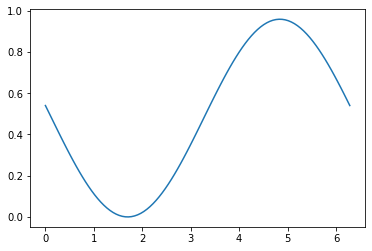

In [12]:
def cry(theta):
    ide = np.identity(4)
    yz = np.kron(np.array([[0, -1j], [1j, 0]]), np.array([[1, 0], [0, -1]]))
    return np.cos(theta/2)*ide - 1j*np.sin(theta/2)*yz

def crx(theta):
    ide = np.identity(4)
    zx = np.kron(np.array([[0, 1], [1, 0]]), np.array([[1, 0], [0, -1]]))
    return np.cos(theta/2)*ide - 1j*np.sin(theta/2)*zx

theta_list = list(np.linspace(0, 2*np.pi, 100))
fid_list = []
for theta in theta_list:
    cr_super = trf.kraus_to_super(cry(theta), my_hs_basis)
    fid_list.append(average_process_fidelity(cr_super, total_sup_op))

plt.plot(theta_list, fid_list)
plt.show()

In [13]:
cr_super_target = trf.kraus_to_super(cry(-np.pi/2), my_hs_basis)
f_pro = average_process_fidelity(cr_super_target, total_sup_op)
display(Latex(r'$F_{{pro}} = {:.5f}$'.format(f_pro)))

<IPython.core.display.Latex object>